# Histogram-Based Segmentation
*Denoise → Inspect histogram → Threshold into phases → Clean with morphology → Visualize & save*

---

## Why Histogram-Based Segmentation?

Histogram-based segmentation is one of the simplest and most effective segmentation strategies when **regions differ by gray level**. The idea is:

1. Convert (or load) an image as grayscale.
2. Examine the histogram of intensities.
3. Choose threshold ranges that correspond to different materials/phases/structures.
4. Create masks for each range.

This approach works best when:
- The image has **separable intensity modes** (distinct peaks in the histogram).
- Different regions correspond to different brightness levels (e.g., **backscattered SEM**, phase contrast under some conditions).

It *fails* or becomes unreliable when:
- Regions have similar mean intensity but differ in **texture** (e.g., scratch assay images).
- Illumination varies strongly across the field.
- Noise causes peaks to overlap.

In those cases, you often need preprocessing such as:
- Texture filters (entropy, local variance, Gabor)
- Background correction (flat-field)
- Or, in tougher cases, machine learning

This tutorial demonstrates histogram-based segmentation on a **backscattered electron SEM image** (downloaded and artificially noised), using a robust pipeline:

> **Non-Local Means denoising → histogram thresholds → multi-class mask → morphological cleanup**

---

### Libraries Used

We’ll use:
- `scikit-image` for I/O, denoising, dtype conversions
- `numpy` for array logic
- `matplotlib` for visualization/histograms
- `scipy.ndimage` for binary morphology cleanup


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import io
from skimage import img_as_float, img_as_ubyte
from skimage.restoration import denoise_nl_means, estimate_sigma

from scipy import ndimage as ndi

---

### Step 1 — Read the Image (and Convert to Float)

Non-local means and many restoration methods work best on float images.

In [4]:
img = img_as_float(io.imread("8.noisyCT.jpg", as_gray=True))

print(f"Image type: {img.dtype}")
print(f"Image minimum: {img.min()}")
print(f"Image maximum: {img.max()}")

Image type: float64
Image minimum: 0.0
Image maximum: 1.0


- `img_as_float` ensures values are in a float range (commonly 0 → 1).
- `as_gray=True` ensures a single-channel grayscale image.

---

### Step 2 — Denoise Using Non-Local Means (NLM)

Non-local means is a strong general-purpose denoiser because it averages similar patches across the image rather than just local neighbors.

#### Estimate noise level (sigma)

In [5]:
sigma_est = np.mean(estimate_sigma(img, channel_axis=None))
print(f"Estimated sigma (noise): {sigma_est}")


Estimated sigma (noise): 0.060981480146990424


#### Configure and run NLM

In [6]:
denoised = denoise_nl_means(
    img,
    h=1.15 * sigma_est,     # controls filtering strength
    patch_size=5,           # size of patches compared
    patch_distance=3,       # search radius for similar patches
    fast_mode=True,         # huge speed boost with minimal quality loss
    channel_axis=None
)

**Key parameters**
- `h`: larger → stronger denoising (but more detail loss)
- `patch_size`: larger → better structure modeling, slower
- `patch_distance`: larger → considers more patches, slower
- `fast_mode=True`: strongly recommended for speed

#### Visualize

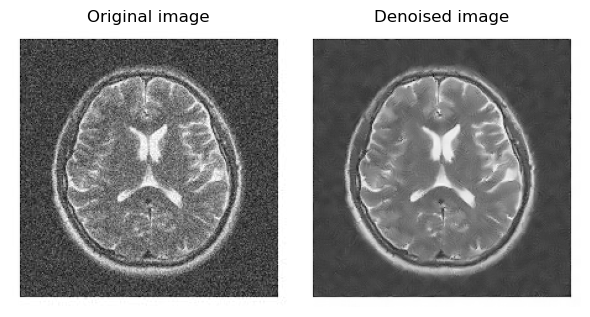

In [8]:
plt.figure(figsize=(6, 7))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap = "gray")
plt.axis("off")
plt.title("Original image")

plt.subplot(1, 2, 2)
plt.imshow(denoised, cmap = "gray")
plt.axis("off")
plt.title("Denoised image")


plt.tight_layout()
plt.show()

---

### Step 3 — Convert to 8-bit Before Histogram Segmentation

Working in 8-bit (`uint8`) makes histogram thresholds intuitive (0–255).

In [9]:
denoised_u8 = img_as_ubyte(denoised)

print(f"Image type: {denoised_u8.dtype}")
print(f"Image minimum: {denoised_u8.min()}")
print(f"Image maximum: {denoised_u8.max()}")

Image type: uint8
Image minimum: 0
Image maximum: 255


---

### Step 4 — Plot the Histogram

Flatten the 2D image into 1D to compute intensity frequency.

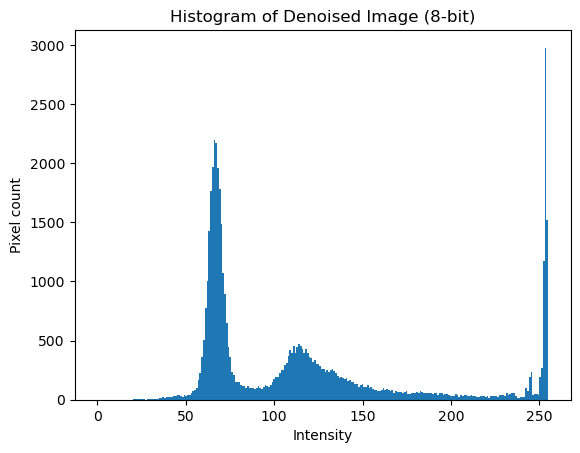

In [10]:
plt.figure()
plt.hist(denoised_u8.ravel(), bins=256, range=(0, 255))
plt.title("Histogram of Denoised Image (8-bit)")
plt.xlabel("Intensity")
plt.ylabel("Pixel count")
plt.show()

#### Zoom in to find valleys between peaks

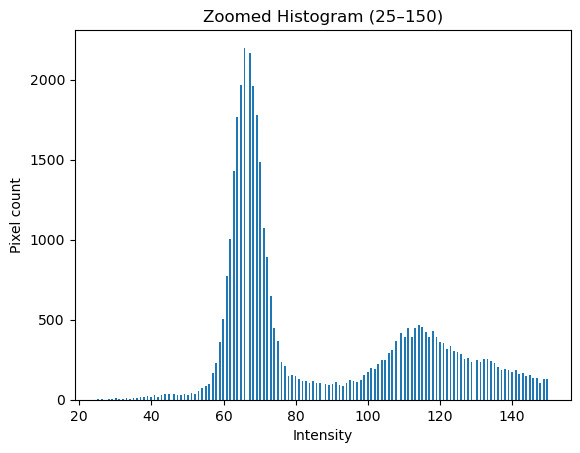

In [11]:
plt.figure()
plt.hist(denoised_u8.ravel(), bins=256, range=(25, 150))
plt.title("Zoomed Histogram (25–150)")
plt.xlabel("Intensity")
plt.ylabel("Pixel count")
plt.show()


You typically choose thresholds at valleys between histogram peaks.

---

### Step 5 — Create Intensity Range Masks (Multi-Class Segmentation)

Here our thresholds are approximately:

- Segment 1: <= 90
- Segment 2: 91–237
- Segment 3: 238–249
- Segment 4: >= 250 (often a bright phase)

> Thresholds depend on your specific image histogram — always validate visually.

In [12]:
seg1 = denoised_u8 <= 90
seg2 = (denoised_u8 > 90) & (denoised_u8 <= 237)
seg3 = (denoised_u8 > 237) & (denoised_u8 <= 249)
seg4 = denoised_u8 >= 250


Each `segX` is a binary mask (`True/False`).

---

### Step 6 — Visualize as a Color Label Image

A quick way to make segmentation “fun” and interpretable is to create an RGB overlay:

In [13]:
H, W = denoised_u8.shape
rgb = np.zeros((H, W, 3), dtype=np.uint8)

rgb[seg1] = (255,   0,   0)   # red
rgb[seg2] = (  0, 255,   0)   # green
rgb[seg3] = (  0,   0, 255)   # blue
rgb[seg4] = (255, 255,   0)   # yellow


Display:

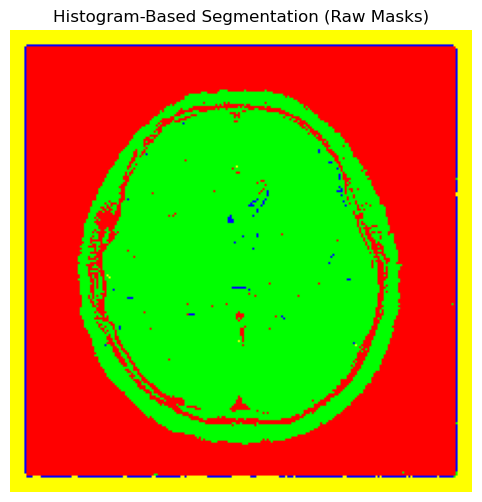

In [14]:
plt.figure(figsize=(8, 6))
plt.imshow(rgb)
plt.title("Histogram-Based Segmentation (Raw Masks)")
plt.axis("off")
plt.show()

Absoloutly this segentation is not representative of brain structures! We only want to show how it can be implemented. 

---

### Step 7 — Clean Masks with Binary Morphology (Opening + Closing)

Histogram segmentation often creates:
- isolated speckles (false positives)
- small holes in regions
- noisy boundaries

A fast cleanup method:
- Opening removes small bright noise
- Closing fills small holes

In [15]:
structure = np.ones((3, 3), dtype=bool)

def clean_mask(mask, structure=structure):
    opened = ndi.binary_opening(mask, structure=structure)
    closed = ndi.binary_closing(opened, structure=structure)
    return closed

seg1_c = clean_mask(seg1)
seg2_c = clean_mask(seg2)
seg3_c = clean_mask(seg3)
seg4_c = clean_mask(seg4)


Rebuild cleaned RGB:

In [16]:
rgb_clean = np.zeros((H, W, 3), dtype=np.uint8)

rgb_clean[seg1_c] = (255,   0,   0)
rgb_clean[seg2_c] = (  0, 255,   0)
rgb_clean[seg3_c] = (  0,   0, 255)
rgb_clean[seg4_c] = (255, 255,   0)


Show cleaned result:

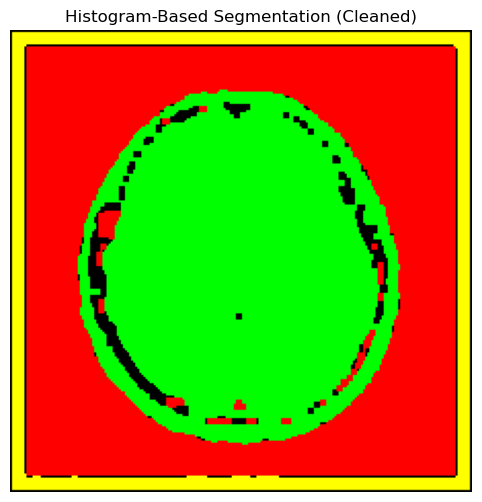

In [17]:
plt.figure(figsize=(8, 6))
plt.imshow(rgb_clean)
plt.title("Histogram-Based Segmentation (Cleaned)")
plt.axis("off")
plt.show()


---

## Improvements Not Explicitly Done Above

Here are practical upgrades you may want in real projects.

### Automatically choose thresholds (when peaks are clear)

Instead of manually picking valleys, we can try:
- Otsu (2-class)
- Multi-Otsu (multi-class)
- Yen, Li, Triangle thresholds

Example: **Multi-Otsu** (great for phase-like SEM images)

In [24]:
### Helper Visualization Functions

def show_images_grid(images, titles=None, cmap="gray", figsize=(12, 6)):
    """Display a list of images in a compact grid."""
    n = len(images)
    cols = min(4, n)
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=figsize)
    for i, im in enumerate(images):
        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(im, cmap=cmap if (im.ndim == 2) else None)
        if titles:
            ax.set_title(titles[i])
        ax.axis("off")
    plt.tight_layout()
    plt.show()

def overlay_mask_on_image(base_u8, mask, alpha=0.45):
    """Overlay a boolean mask on a grayscale base image for quick inspection."""
    base_rgb = np.stack([base_u8]*3, axis=-1)
    overlay = base_rgb.copy()
    overlay[mask] = [255, 0, 0]  # red overlay
    out = (1 - alpha) * base_rgb + alpha * overlay
    return out.astype(np.uint8)

Multi-Otsu thresholds: [ 93 144 209]


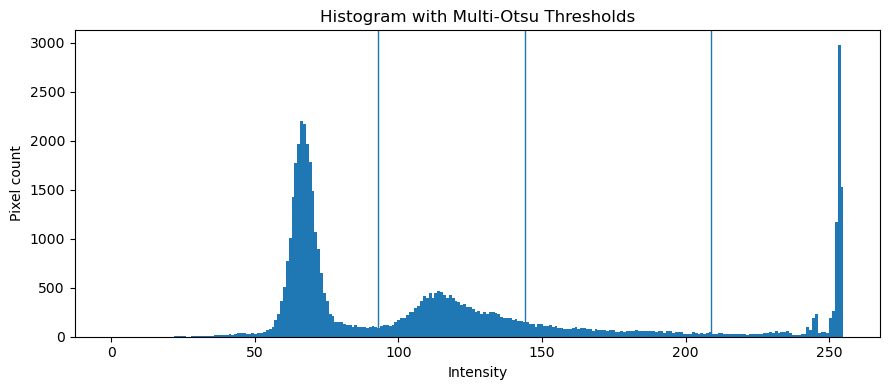

In [36]:
from skimage.filters import threshold_multiotsu

thresholds = threshold_multiotsu(denoised_u8, classes=4)
print("Multi-Otsu thresholds:", thresholds)


plt.figure(figsize=(9, 4))
plt.hist(denoised_u8.ravel(), bins=256, range=(0, 255))
for t in thresholds:
    plt.axvline(t, linewidth=1)
plt.title("Histogram with Multi-Otsu Thresholds")
plt.xlabel("Intensity")
plt.ylabel("Pixel count")
plt.tight_layout()
plt.show()

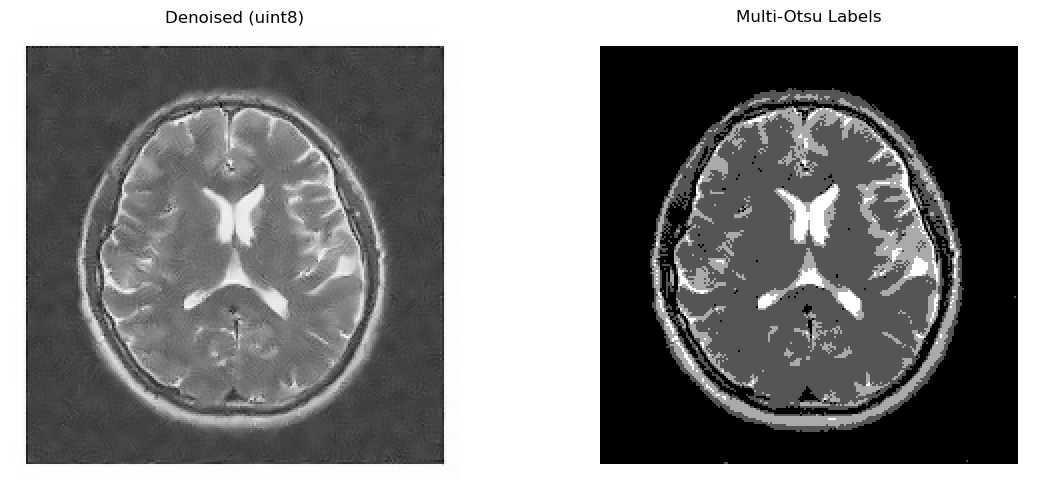

In [26]:
regions = np.digitize(denoised_u8, bins=thresholds)  # labels: 0..3
show_images_grid([denoised_u8, regions],
                 ["Denoised (uint8)", "Multi-Otsu Labels"],
                 cmap="gray", figsize=(12, 5))

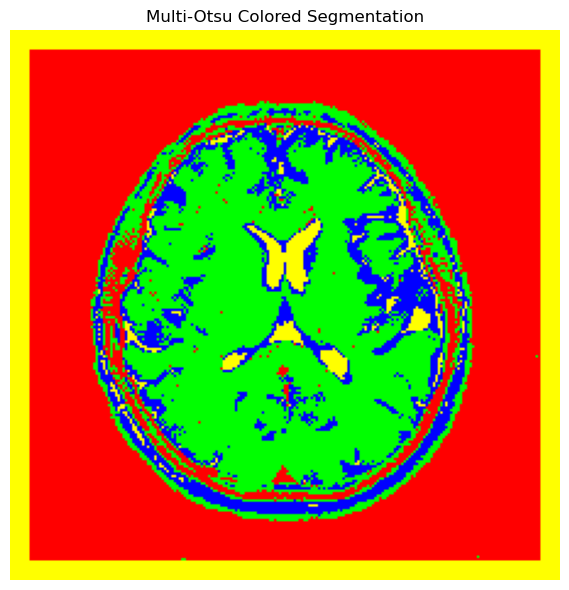

In [27]:
# Simple label -> color mapping
palette = np.array([
    [255,   0,   0],  # label 0 -> red
    [  0, 255,   0],  # label 1 -> green
    [  0,   0, 255],  # label 2 -> blue
    [255, 255,   0],  # label 3 -> yellow
], dtype=np.uint8)

rgb_multiotsu = palette[regions]  # shape (H, W, 3)

show_images_grid([rgb_multiotsu], ["Multi-Otsu Colored Segmentation"], figsize=(7, 6))


> Tip: Multi-Otsu can outperform manual thresholds when peaks are reasonably separated, but it can still struggle with heavy overlap.